In [115]:
import json
from glob import glob
import pandas as pd
import numpy as np
import evaluate

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load data

In [40]:
outputs = glob("../output/*.json")
results = pd.DataFrame()

for fname in outputs:
  with open(fname) as f:
    output = json.load(f)
  
  meta = { 
    "file_name": fname,
    "dataset": output["args"]["dataset"],
    "model": output["args"]["model"],
    "template": output["args"]["template"], "max_length": output["args"]["max_length"]
  }


  for sample in output["results"]:
    data = {
      **meta, 
      "target": sample["data"]["target_description"]["comment"], 
      "pred": sample["output"]
    }
    df = pd.DataFrame({k: [v] for k, v in data.items() })
    results = pd.concat([results, df], ignore_index=True)

In [41]:
results.head()

,file_name,dataset,model,template,max_length,target,pred
0,../output/23-11-29_0621.json,datasets/frbr_100_3/,meta-llama/Llama-2-7b-chat-hf,prompt_2_role,150,This class represents any of the FRBR group th...,This class corresponds to the FRBR group three...
1,../output/23-11-29_0621.json,datasets/frbr_100_3/,meta-llama/Llama-2-7b-chat-hf,prompt_2_role,150,This class corresponds to the FRBR group two e...,This class corresponds to the FRBR group two e...
2,../output/23-11-29_0621.json,datasets/frbr_100_3/,meta-llama/Llama-2-7b-chat-hf,prompt_2_role,150,This class represents any one of the FRBR grou...,This class represents any endeavor.
3,../output/23-11-29_0621.json,datasets/frbr_100_3/,meta-llama/Llama-2-7b-chat-hf,prompt_2_role,150,This class corresponds to the FRBR group three...,This class corresponds to the FRBR group one e...
4,../output/23-11-29_0621.json,datasets/frbr_100_3/,meta-llama/Llama-2-7b-chat-hf,prompt_2_role,150,This class represents any one of the FRBR grou...,This class corresponds to the FRBR group three...


Compute the metrics

In [65]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")
chrf = evaluate.load("chrf")
meteor = evaluate.load("meteor")

def compute_metrics(pred, true):
    pred = [pred]
    refs = [true]

    bert_score = bertscore.compute(predictions=pred, references=refs, lang="en", device=1)
    return {
        **rouge.compute(predictions=pred, references=refs),
        **meteor.compute(predictions=pred, references=refs),
        "bertscore_precision": bert_score["precision"][0],
        "bertscore_recall": bert_score["recall"][0],
        "bertscore_f1": bert_score["f1"][0],
        "chrf": chrf.compute(predictions=pred, references=refs)["score"],
        "chrf+": chrf.compute(predictions=pred, references=refs, word_order=1)["score"],
        "chrf++": chrf.compute(predictions=pred, references=refs, word_order=2)["score"],
    }

# compute metrics
#metrics = results.progress_apply(lambda row: compute_metrics(row.pred, row.target), axis=1)
new_metrics = results_w_metrics[results_w_metrics.isna().any(axis=1)].progress_apply(lambda row: compute_metrics(row.pred, row.target), axis=1)

# join metrics into main results
#results = results.join(pd.DataFrame.from_dict({i: m for i, m in enumerate(metrics)}, orient="index"))

# save resultswith metrics
#results.to_csv("./evaluation.csv")

[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nicolas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  0%|                                                                                          | 0/1500 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:05<00:00,  6.12it/s]


## Load results

In [298]:
results = pd.read_csv("evaluation.csv", index_col=0)
results.loc[results.pred.isna(), "pred"] = ""
results.loc[results.target.isna(), "target"] = ""

metrics_cols = results.columns[7:]

results["word_diff"] = results.apply(lambda row: len(row.target.split()) - len(row.pred.split()), axis=1)

METRICS = ["bertscore_f1", "meteor", "rougeL", "chrf", "chrf+", "chrf++"]
results["mean_metric"] = results[METRICS].mean(axis=1)

results["is_role"] = results.template.str.contains("role")
results["prompt_name"] = results.template.apply(lambda s: s.replace("_role", "") if "role" in s else s)

Mean metrics for each model among each prompt

In [80]:
metrics_df = results.groupby(["dataset", "model"])[METRICS].mean()[METRICS]
metrics_df

bertscore_f1  \
dataset                   model                                         
datasets/arco_100_3/      Intel/neural-chat-7b-v3-1          0.860464   
                          baseline                           0.833553   
                          meta-llama/Llama-2-7b-chat-hf      0.845650   
                          tiiuae/falcon-7b-instruct          0.859713   
datasets/dbpedia_100_3/   Intel/neural-chat-7b-v3-1          0.830971   
                          baseline                           0.760402   
                          meta-llama/Llama-2-7b-chat-hf      0.809124   
                          tiiuae/falcon-7b-instruct          0.839772   
datasets/dul_100_3/       Intel/neural-chat-7b-v3-1          0.856090   
                          baseline                           0.830303   
                          meta-llama/Llama-2-7b-chat-hf      0.837982   
                          tiiuae/falcon-7b-instruct          0.857195   
datasets/foodon_100_3/    Intel/neural-chat-7b-v3-1          0.844735   
                          baseline                           0.783837   
                          meta-llama/Llama-2-7b-chat-hf      0.845180   
                          tiiuae/falcon-7b-instruct          0.843969   
datasets/frbr_100_3/      Intel/neural-chat-7b-v3-1          0.832808   
                          baseline                           0.802582   
                          meta-llama/Llama-2-7b-chat-hf      0.858180   
                          tiiuae/falcon-7b-instruct          0.827388   
datasets/go_100_3/        Intel/neural-chat-7b-v3-1          0.813386   
                          baseline                           0.244375   
                          meta-llama/Llama-2-7b-chat-hf      0.849022   
                          tiiuae/falcon-7b-instruct          0.856956   
datasets/helis_100_3/     Intel/neural-chat-7b-v3-1          0.853972   
                          baseline                           0.862753   
                          meta-llama/Llama-2-7b-chat-hf      0.835904   
                          tiiuae/falcon-7b-instruct          0.812426   
datasets/schemaorg_100_3/ Intel/neural-chat-7b-v3-1          0.814988   
                          baseline                           0.836013   
                          meta-llama/Llama-2-7b-chat-hf      0.838663   
                          tiiuae/falcon-7b-instruct          0.855283   

                                                           meteor    rougeL  \
dataset                   model                                               
datasets/arco_100_3/      Intel/neural-chat-7b-v3-1      0.269760  0.256027   
                          baseline                       0.155732  0.136539   
                          meta-llama/Llama-2-7b-chat-hf  0.201845  0.192570   
                          tiiuae/falcon-7b-instruct      0.320284  0.294612   
datasets/dbpedia_100_3/   Intel/neural-chat-7b-v3-1      0.214199  0.192459   
                          baseline                       0.096119  0.119657   
                          meta-llama/Llama-2-7b-chat-hf  0.203526  0.203123   
                          tiiuae/falcon-7b-instruct      0.251443  0.243513   
datasets/dul_100_3/       Intel/neural-chat-7b-v3-1      0.329122  0.307442   
                          baseline                       0.100457  0.094489   
                          meta-llama/Llama-2-7b-chat-hf  0.254338  0.246329   
                          tiiuae/falcon-7b-instruct      0.264453  0.250463   
datasets/foodon_100_3/    Intel/neural-chat-7b-v3-1      0.296121  0.279806   
                          baseline                       0.053043  0.048575   
                          meta-llama/Llama-2-7b-chat-hf  0.242502  0.237404   
                          tiiuae/falcon-7b-instruct      0.235831  0.232567   
datasets/frbr_100_3/      Intel/neural-chat-7b-v3-1      0.286608  0.258526   
                          baseline                       0.073569  0.0894

In [39]:
print(metrics_df.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 &  & bertscore_f1 & meteor & rougeL & chrf & chrf+ & chrf++ \\
dataset & model &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{datasets/arco_100_3/} & Intel/neural-chat-7b-v3-1 & 0.86 & 0.27 & 0.26 & 29.75 & 29.98 & 28.06 \\
 & baseline & 0.83 & 0.16 & 0.14 & 24.94 & 23.87 & 21.35 \\
 & meta-llama/Llama-2-7b-chat-hf & 0.85 & 0.20 & 0.19 & 25.64 & 25.39 & 23.18 \\
 & tiiuae/falcon-7b-instruct & 0.86 & 0.32 & 0.29 & 33.71 & 33.89 & 32.12 \\
\cline{1-8}
\multirow[t]{4}{*}{datasets/dbpedia_100_3/} & Intel/neural-chat-7b-v3-1 & 0.83 & 0.21 & 0.19 & 24.00 & 24.02 & 22.34 \\
 & baseline & 0.76 & 0.10 & 0.12 & 17.89 & 17.08 & 15.14 \\
 & meta-llama/Llama-2-7b-chat-hf & 0.81 & 0.20 & 0.20 & 22.90 & 22.91 & 21.43 \\
 & tiiuae/falcon-7b-instruct & 0.84 & 0.25 & 0.24 & 27.58 & 27.67 & 26.07 \\
\cline{1-8}
\multirow[t]{4}{*}{datasets/dul_100_3/} & Intel/neural-chat-7b-v3-1 & 0.86 & 0.33 & 0.31 & 34.33 & 34.51 & 32.87 \\
 & baseline & 0.83 & 0.10 & 0.09 & 17.03 &

Compute number word length difference

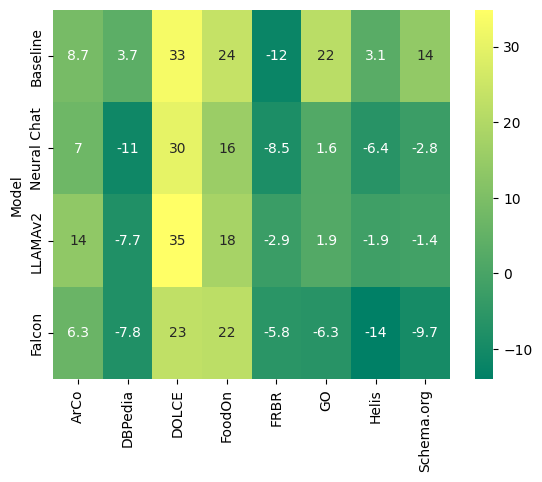

In [248]:
word_diff = pd.DataFrame(results.groupby(["model", "dataset"])["word_diff"].mean()).reset_index()
word_diff = word_diff.pivot_table(index="model", columns="dataset", values="word_diff")
word_diff = word_diff.iloc[[1, 0, 2, 3]].reset_index()

word_diff.model = word_diff.model.map({
  "baseline": "Baseline", 
  "Intel/neural-chat-7b-v3-1": "Neural Chat",
  "meta-llama/Llama-2-7b-chat-hf": "LLAMAv2",
  "tiiuae/falcon-7b-instruct": "Falcon",
  })

word_diff.columns = ['Model', 'ArCo', 'DBPedia', 'DOLCE', 'FoodOn', 'FRBR', 'GO', 'Helis', 'Schema.org']
word_diff = word_diff.set_index("Model")

sns.heatmap(word_diff, annot=True, cmap="summer").get_figure().savefig("images/word_count.png", dpi=300, bbox_inches = 'tight')

Compare the standard deviation within each score

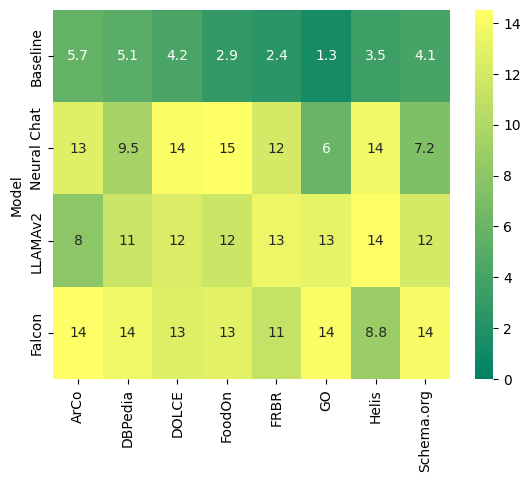

In [249]:
std = pd.DataFrame(results.groupby(["model", "dataset"])[METRICS].std().mean(axis=1)).reset_index()
std.columns = ["model", "dataset", "std"]
std = std.pivot_table(index="model", columns="dataset", values="std")
std = std.iloc[[1, 0, 2, 3]].reset_index()

std.model = std.model.map({
  "baseline": "Baseline", 
  "Intel/neural-chat-7b-v3-1": "Neural Chat",
  "meta-llama/Llama-2-7b-chat-hf": "LLAMAv2",
  "tiiuae/falcon-7b-instruct": "Falcon",
  })

std.columns = ['Model', 'ArCo', 'DBPedia', 'DOLCE', 'FoodOn', 'FRBR', 'GO', 'Helis', 'Schema.org']
std = std.set_index("Model")
sns.heatmap(std, annot=True, vmin=0, cmap="summer").get_figure().savefig("images/score_std.png", dpi=300, bbox_inches = 'tight')

In [307]:
print(results.groupby(["prompt_name", "is_role"])["mean_metric"].mean().to_latex())

\begin{tabular}{llr}
\toprule
 &  & mean_metric \\
prompt_name & is_role &  \\
\midrule
baseline & False & 7.341724 \\
\cline{1-3}
\multirow[t]{2}{*}{prompt_0} & False & 12.762473 \\
 & True & 15.739394 \\
\cline{1-3}
\multirow[t]{2}{*}{prompt_1} & False & 12.787591 \\
 & True & 14.781456 \\
\cline{1-3}
\multirow[t]{2}{*}{prompt_2} & False & 14.485164 \\
 & True & 14.230083 \\
\cline{1-3}
\multirow[t]{2}{*}{prompt_3} & False & 11.798156 \\
 & True & 12.280832 \\
\cline{1-3}
\multirow[t]{2}{*}{prompt_4} & False & 14.066770 \\
 & True & 17.113721 \\
\cline{1-3}
\bottomrule
\end{tabular}



In [358]:
target = results[(results.dataset == "datasets/dbpedia_100_3/")].iloc[2].target
sample = results[(results.model == "tiiuae/falcon-7b-instruct") & (results.target == target) & (results.template == "prompt_2")].iloc[0]
sample.target

'Color or colour is the visual perceptual property corresponding in humans to the categories called red, yellow, blue and others. Color derives from the spectrum of light (distribution of light energy versus wavelength) interacting in the eye with the spectral sensitivities of the light receptors.'

In [365]:
target = results[(results.dataset == "datasets/dbpedia_100_3/")].iloc[2].target
sample = results[(results.model == "baseline") & (results.target == target) & (results.template == "baseline")].iloc[0]
sample.pred

'colour generalises Thing.'

In [375]:
target = results[(results.dataset == "datasets/dbpedia_100_3/")].iloc[2].target
sample = results[(results.model == "tiiuae/falcon-7b-instruct") & (results.target == target) & (results.template == "prompt_4_role")].iloc[0]
sample.pred

'The comment of the class is a description of the class and its range.'